In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder




In [2]:
random.seed(0)

In [3]:
## loading the file
health_care = pd.read_csv('../healthcare/train_data.csv', na_values=['NA', 'NaN', '?'])

In [4]:
# Dropping these columns for now
health_care = health_care.dropna()

## Feature engineering

We will add 2 features : 
- Visit number
- New Patient

In [5]:
n = health_care.shape[0]
visits = []
patientid = np.array(health_care['patientid'])
for i in range(n) :
    count = (patientid[:i+1] == patientid[i]).sum()
    visits.append(count)
    
health_care['Visit Number'] = visits
health_care['New Patient'] = (health_care['Visit Number']==1).astype('int32')

## Label Encoded Data

In [6]:
## Pre processing these columns

string_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',  'Type of Admission', 'Severity of Illness', 'Age' ]
encoder = LabelEncoder()
ohEncoder = OneHotEncoder()

## label_encoded data
X_le = health_care.drop(['Stay', 'case_id'], axis=1)
y_le = health_care['Stay']

y_le = encoder.fit_transform(y_le)
for column in string_columns :
    X_le[column] = encoder.fit(X_le[column]).transform(X_le[column])
    

In [7]:
y_le = 10*y_le + 5

## Hot encoded Data

In [8]:
# Function to hot encode the column with name : name for dataframe df
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True) ## inplace to make changed on the original df

In [9]:
## Pre processing these columns

le_string_columns = [  'Severity of Illness', 'Age' ]
dummies_string_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',  'Type of Admission']
encoder = LabelEncoder()
#ohEncoder = OneHotEncoder()

## label_encoded data
Xe = health_care.drop(['Stay', 'case_id'], axis=1)
Xe['Severity of Illness']= Xe['Severity of Illness'].map({'Minor': 0,  'Moderate': 1,'Extreme': 2})
Xe['Age'] = encoder.fit_transform(Xe['Age'])

ye = health_care['Stay']
ye = encoder.fit_transform(ye)
ye = 10*ye + 5
ye

for column in dummies_string_columns :
    encode_text_dummy(Xe, column)
    

## Scaling Label Encoded Data

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = X_le.values
y = y_le
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

## Lasso for feature selection

In [11]:
def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': np.abs(coef)  }, index = names )
    r = r.sort_values(by=['positive'], ascending=True)
    display(r)
    print("Intercept: {}".format(intercept))
    plt.xlabel('covariate coefficient')
    r['coef'].plot(kind='barh')

In [12]:
import sklearn
from sklearn.linear_model import Lasso
from sklearn import metrics

# Create linear regression
regressor = Lasso(alpha=0.1)

# Fit/train LASSO
regressor.fit(X_train,y_train)
# Predict
X_pred = regressor.predict(X_test)

a= regressor.coef_
b = regressor.intercept_
c = np.sqrt(metrics.mean_squared_error(X_pred,y_test))

print('RMSE : %.2f' % c)
print('score : %.2f' % regressor.score(X_train,y_train))



RMSE : 17.01
score : 0.37


,coef,positive
patientid,-0.000000,0.000000
City_Code_Patient,-0.056820,0.056820
Admission_Deposit,0.087787,0.087787
Visit Number,-0.200844,0.200844
Hospital_region_code,0.246487,0.246487
Severity of Illness,-0.253918,0.253918
Hospital_type_code,0.439190,0.439190
Department,0.486087,0.486087
Ward_Facility_Code,0.507510,0.507510
Hospital_code,0.519537,0.519537


Intercept: 31.985858997892446


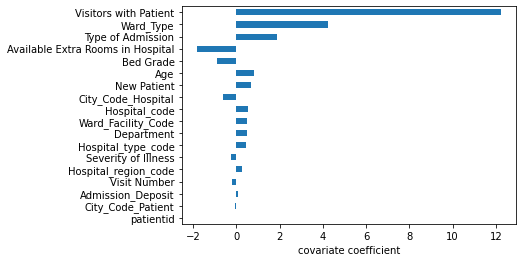

In [13]:
names = list(X_le.columns.values)
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

# ANN

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping


In [16]:
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(X_train,y_train,verbose=1,epochs=100)
pred = model.predict(X_test)
# Measure RMSE error.  
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Train on 235344 samples
Epoch 1/100
235344/235344 [==============================] - 6s 27us/sample - loss: 323.3432
Epoch 2/100
235344/235344 [==============================] - 6s 25us/sample - loss: 264.1669
Epoch 3/100
235344/235344 [==============================] - 6s 25us/sample - loss: 258.9427
Epoch 4/100
235344/235344 [==============================] - 6s 25us/sample - loss: 255.8869
Epoch 5/100
235344/235344 [==============================] - 6s 26us/sample - loss: 253.7916
Epoch 6/100
235344/235344 [==============================] - 6s 26us/sample - loss: 252.5964
Epoch 7/100
235344/235344 [==============================] - 6s 25us/sample - loss: 251.8222
Epoch 8/100
235344/235344 [==============================] - 6s 26us/sample - loss: 251.1297
Epoch 9/100
235344/235344 [==============================] - 6s 26us/sample - loss: 250.52060s - loss: 
Epoch 10/100
235344/235344 [==============================] - 6s 26us/sample - loss: 250.0956
Epoch 11/100
235344/235344 [======

235344/235344 [==============================] - 6s 25us/sample - loss: 240.7425
Epoch 87/100
235344/235344 [==============================] - 6s 25us/sample - loss: 240.6482
Epoch 88/100
235344/235344 [==============================] - 6s 26us/sample - loss: 240.5364
Epoch 89/100
235344/235344 [==============================] - 6s 26us/sample - loss: 240.5522
Epoch 90/100
235344/235344 [==============================] - 6s 25us/sample - loss: 240.5767
Epoch 91/100
235344/235344 [==============================] - 6s 26us/sample - loss: 240.4813
Epoch 92/100
235344/235344 [==============================] - 6s 27us/sample - loss: 240.4587
Epoch 93/100
235344/235344 [==============================] - 6s 26us/sample - loss: 240.37600s - loss: 240.
Epoch 94/100
235344/235344 [==============================] - 6s 26us/sample - loss: 240.4929
Epoch 95/100
235344/235344 [==============================] - 6s 25us/sample - loss: 240.3578
Epoch 96/100
235344/235344 [==============================

In [18]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_score = np.sqrt(metrics.mean_squared_error(train_pred,y_train))
test_score = np.sqrt(metrics.mean_squared_error(test_pred,y_test))

print("Train score (RMSE): {}".format(train_score))
print("Test score (RMSE): {}".format(test_score))


Train score (RMSE): 15.47352174800085
Test score (RMSE): 15.468214916648302


### Ploting train,val errors

In [21]:
from tensorflow.keras import regularizers
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu',kernel_regularizer=regularizers.l1(0.01)))
#model.add(Dense(64, input_dim=x.shape[1], activation='relu',activity_regularizer=regularizers.l2(0.01)))
#model.add(Dense(64, input_dim=x.shape[1], activation='relu',
#                kernel_regularizer=regularizers.l2(0.01),
#                activity_regularizer=regularizers.l1(0.01),activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
#note the return here, with the data from training stroed in training_trace
#also note the validation split
training_trace = model.fit(X_train,y_train,callbacks=[monitor],validation_split=0.25,verbose=1,epochs=1000)



Train on 176508 samples, validate on 58836 samples
Epoch 1/1000
176508/176508 [==============================] - 6s 34us/sample - loss: 342.2163 - val_loss: 274.3539
Epoch 2/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 272.0132 - val_loss: 266.6133
Epoch 3/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 266.8710 - val_loss: 263.1089
Epoch 4/1000
176508/176508 [==============================] - 6s 31us/sample - loss: 263.6709 - val_loss: 260.7205
Epoch 5/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 260.9340 - val_loss: 258.1467
Epoch 6/1000
176508/176508 [==============================] - 6s 31us/sample - loss: 258.2258 - val_loss: 255.7305
Epoch 7/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 256.3349 - val_loss: 253.9840
Epoch 8/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 255.0272 - val_loss: 253.4044
Epoch 9/1000
176508/176508 [=

176508/176508 [==============================] - 6s 32us/sample - loss: 245.1843 - val_loss: 245.5591
Epoch 72/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 245.2849 - val_loss: 245.7491
Epoch 73/1000
176508/176508 [==============================] - 6s 31us/sample - loss: 245.1917 - val_loss: 245.4221
Epoch 74/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 245.1536 - val_loss: 245.4978
Epoch 75/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 245.2182 - val_loss: 244.6482
Epoch 76/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 245.0860 - val_loss: 246.2591
Epoch 77/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 245.1530 - val_loss: 245.1886ETA: 0s - loss: 245.61 - ETA: 0s - loss: 245.25
Epoch 78/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 245.2397 - val_loss: 244.0080
Epoch 79/1000
176508/176508 [==========

176508/176508 [==============================] - 6s 32us/sample - loss: 243.8375 - val_loss: 243.9253
Epoch 141/1000
176508/176508 [==============================] - 6s 31us/sample - loss: 243.6593 - val_loss: 244.0610
Epoch 142/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 243.7323 - val_loss: 243.4987
Epoch 143/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 243.6994 - val_loss: 242.9892
Epoch 144/1000
176508/176508 [==============================] - 6s 31us/sample - loss: 243.6763 - val_loss: 243.4580
Epoch 145/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 243.5717 - val_loss: 242.8601
Epoch 146/1000
176508/176508 [==============================] - 6s 31us/sample - loss: 243.6061 - val_loss: 243.3973
Epoch 147/1000
176508/176508 [==============================] - 6s 32us/sample - loss: 243.5468 - val_loss: 243.0604
Epoch 148/1000
176508/176508 [==============================] - 6s 32us/sample 

ValueError: Found input variables with inconsistent numbers of samples: [235344, 78449]

Train score (RMSE): 15.47051903126435
Test score (RMSE): 15.456265995118082


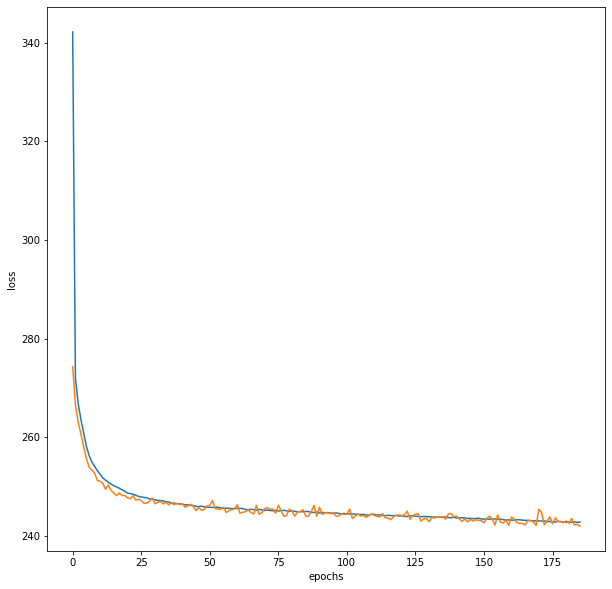

In [22]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_score = np.sqrt(metrics.mean_squared_error(train_pred,y_train))
test_score = np.sqrt(metrics.mean_squared_error(test_pred,y_test))

print("Train score (RMSE): {}".format(train_score))
print("Test score (RMSE): {}".format(test_score))


## plot the loss on the training data, and also the validation data
plt.figure(figsize=(10,10))

plt.plot(training_trace.history['loss'])
plt.plot(training_trace.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


Another Model

Epoch 00134: early stopping
Train score (RMSE): 15.453415049036947
Test score (RMSE): 15.47784997985775


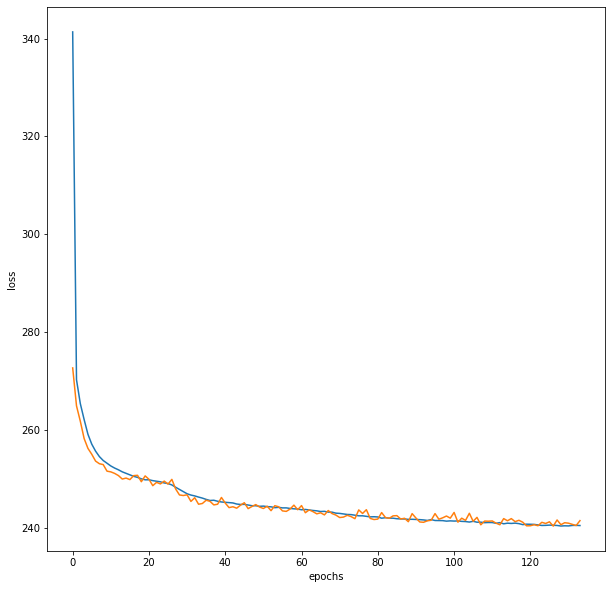

In [24]:
model = Sequential()
#model.add(Dense(64, input_dim=X.shape[1], activation='relu',kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(64, input_dim=X.shape[1], activation='relu',activity_regularizer=regularizers.l2(0.01)))
#model.add(Dense(64, input_dim=x.shape[1], activation='relu',
#                kernel_regularizer=regularizers.l2(0.01),
#                activity_regularizer=regularizers.l1(0.01),activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
#note the return here, with the data from training stroed in training_trace
#also note the validation split
training_trace = model.fit(X_train,y_train,callbacks=[monitor],validation_split=0.25,verbose=0,epochs=1000)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_score = np.sqrt(metrics.mean_squared_error(train_pred,y_train))
test_score = np.sqrt(metrics.mean_squared_error(test_pred,y_test))

print("Train score (RMSE): {}".format(train_score))
print("Test score (RMSE): {}".format(test_score))


## plot the loss on the training data, and also the validation data
plt.figure(figsize=(10,10))

plt.plot(training_trace.history['loss'])
plt.plot(training_trace.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Another one

In [26]:
model = Sequential()
#model.add(Dense(64, input_dim=X.shape[1], activation='relu',kernel_regularizer=regularizers.l1(0.01)))
#model.add(Dense(64, input_dim=x.shape[1], activation='relu',activity_regularizer=regularizers.l2(0.01)))
model.add(Dense(64, input_dim=X.shape[1], activation='relu',
                kernel_regularizer=regularizers.l2(0.01),
               activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
#note the return here, with the data from training stroed in training_trace
#also note the validation split
training_trace = model.fit(X_train,y_train,callbacks=[monitor],validation_split=0.25,verbose=0,epochs=1000)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_score = np.sqrt(metrics.mean_squared_error(train_pred,y_train))
test_score = np.sqrt(metrics.mean_squared_error(test_pred,y_test))

print("Train score (RMSE): {}".format(train_score))
print("Test score (RMSE): {}".format(test_score))


## plot the loss on the training data, and also the validation data
plt.figure(figsize=(10,10))

plt.plot(training_trace.history['loss'])
plt.plot(training_trace.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

KeyboardInterrupt: 